In [1]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt

import os
import sys
sys.path.append('../code')

from pomegranate import HiddenMarkovModel, DiscreteDistribution, NormalDistribution

Chargement des fichiers audio ...
_loadWaveFiles_: using path = /Users/pierre/Desktop/tp-hmm-markov/data/audio
_loadWaveFiles_: entries = ['apple', '.DS_Store', 'kiwi', 'lime', 'banana', 'pineapple', 'orange', 'peach']
Mots trouvés: ['apple', 'kiwi', 'lime', 'banana', 'pineapple', 'orange', 'peach']
Nombre total de mots: 105
Chargement terminé ...
Extraction des features ...
Extraction des features terminée ...
Les mots disponibles dans le dossier /Users/pierre/Desktop/tp-hmm-markov/data/audio sont :
['apple', 'kiwi', 'lime', 'banana', 'pineapple', 'orange', 'peach']


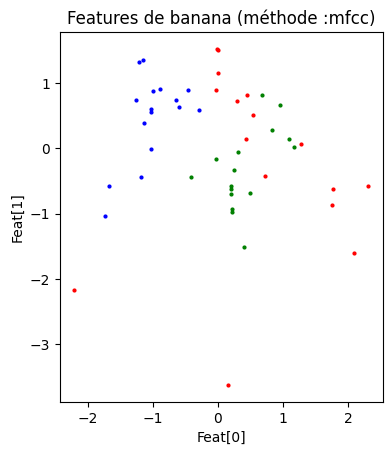

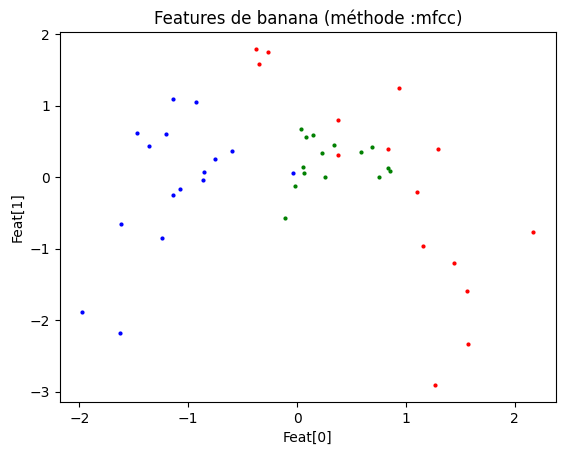

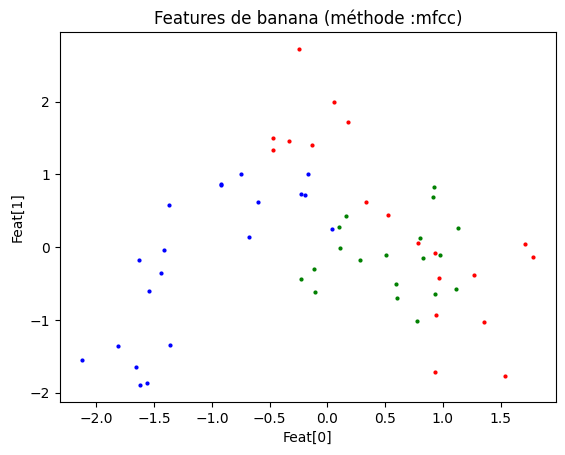

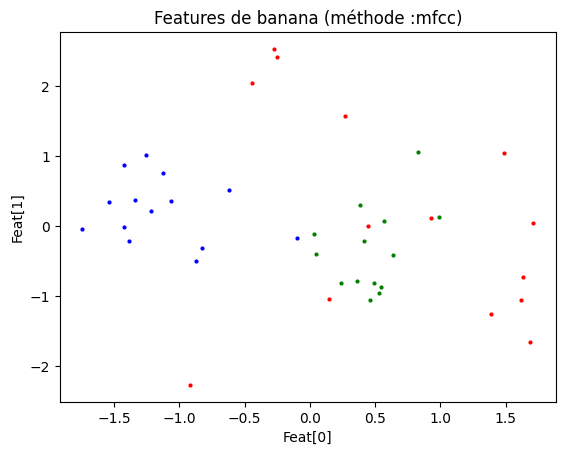

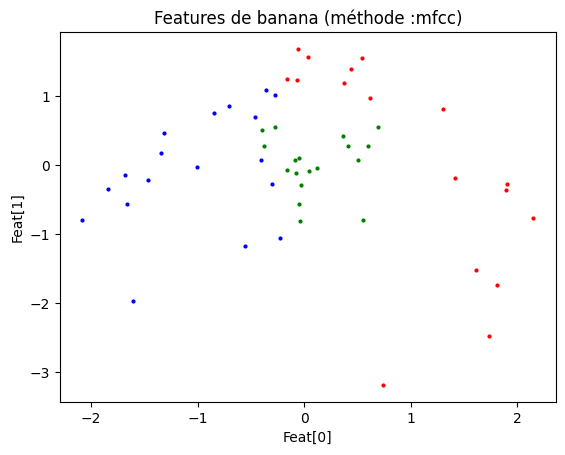

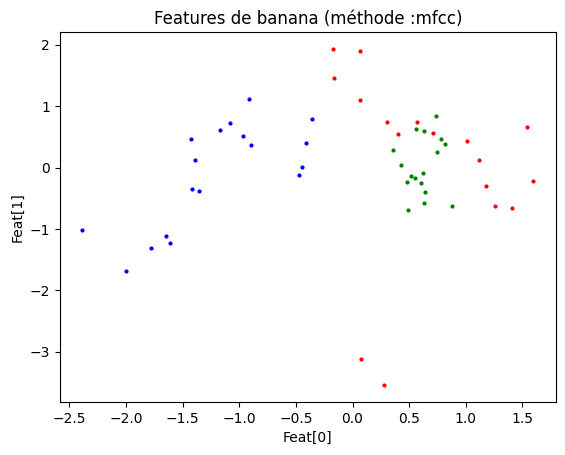

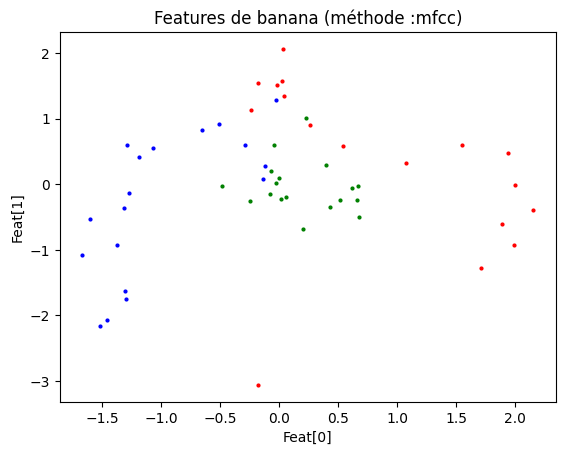

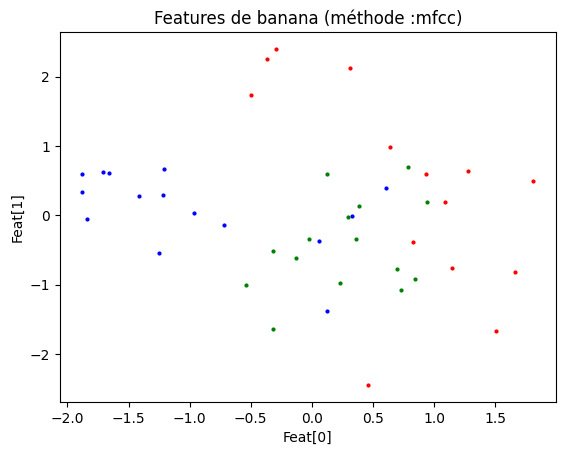

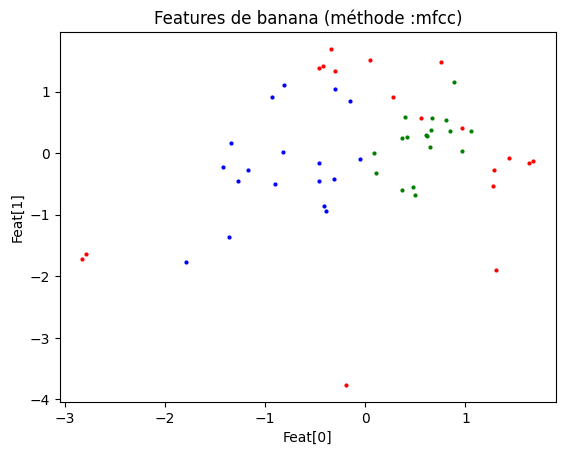

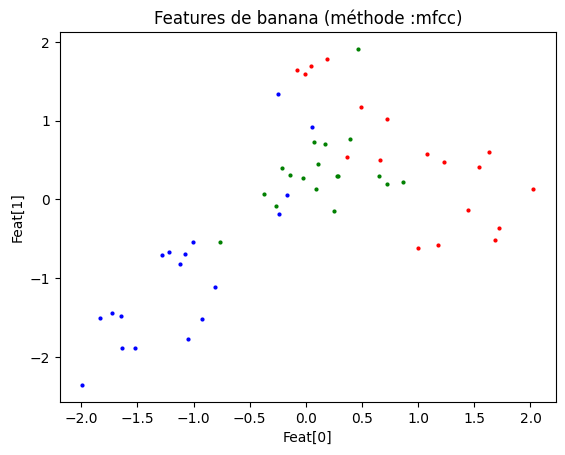

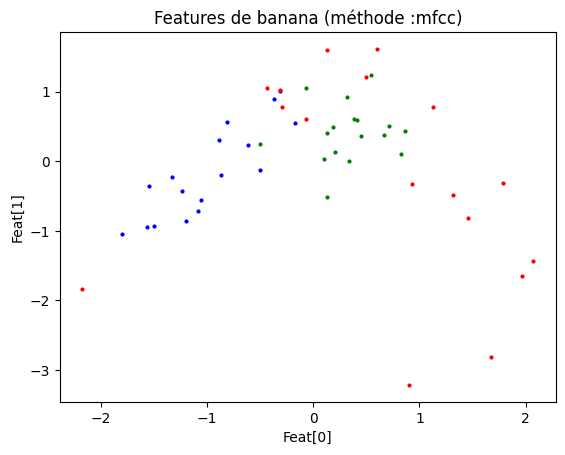

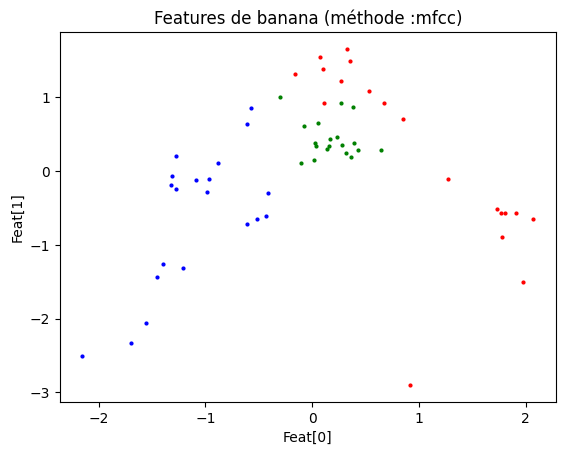

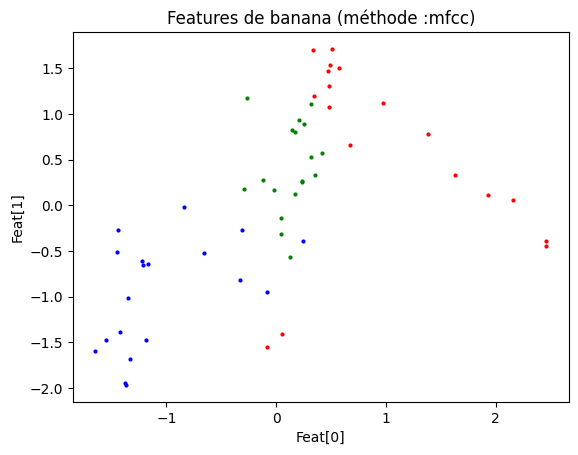

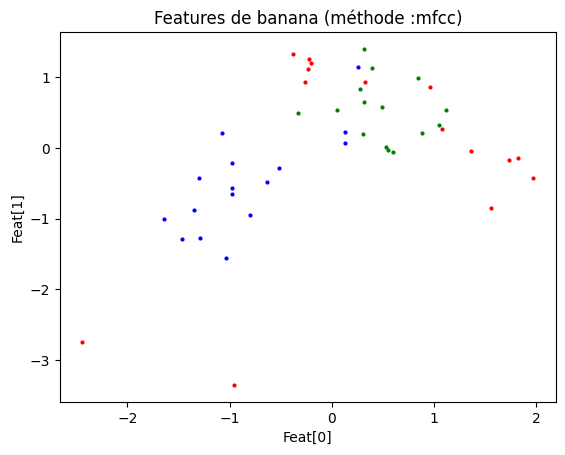

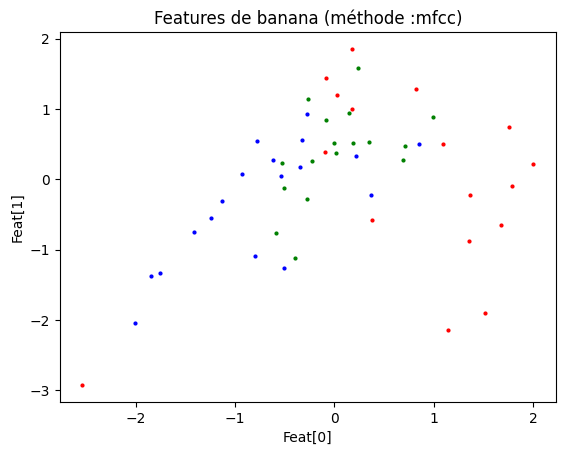

In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
@author: barthes
Version 1.4
revision nov 2024
revision nov 2025
Script permettant de charger les fichiers audio et de calculer les features de chaque trame à l'aide des 3 méthodes disponibles (spectrum, filter et mfcc)
Affichage de la série temporelle d'un mot + différentes repésentations des features pour les 3 méthodes 
"""
#%%
from TpHmmUtilit import Words
import matplotlib.pyplot as plt
import os

#%% On choit un des mots
winlen=0.02         # taille d'une frame en seconde
winstep=0.01        # decalage temporel entre une frame et la suivante en seconde
nfft=256            # Méthode Spectrum : Nombre de points pour le calcul de la FFT => spectre nfft/2 + 1 valeurs
nfilt=26            # Méthode filter : Nonbre de filtres calculés 
numcep=12           # Méthode mfcc : Nombre de coefficients de Mel  
dossierAudio = os.path.abspath(os.path.join(os.getcwd(), '..', 'data', 'audio'))

words=Words(rep=dossierAudio,name='exemple 1',numcep=numcep,winlen=winlen,winstep=winstep,nfilt=nfilt,nfft=nfft,filterLow=False,noise=0)

listeDesMotsDisponibles = words.getLabels()
print('Les mots disponibles dans le dossier {} sont :\n{}'.format(dossierAudio,listeDesMotsDisponibles))

#%% On choit un des mots
myWord='banana'      # mot choisi parmi 'apple', 'banana', 'kiwi', 'lime', 'orange', 'peach', 'pineapple'

#%%
# Affiche l'enregistrement d'un mot et ses features pour les 3 méthodes d'extraction
"""record = 0
words.plotOneWord(label=myWord,num=record)
record = 1
words.plotOneWord(label=myWord,num=record)
record = 2
words.plotOneWord(label=myWord,num=record)
record = 3
words.plotOneWord(label=myWord,num=record)
record = 4
words.plotOneWord(label=myWord,num=record)
record = 5
words.plotOneWord(label=myWord,num=record)
record = 6
words.plotOneWord(label=myWord,num=record)
record = 7
words.plotOneWord(label=myWord,num=record)
record = 8
words.plotOneWord(label=myWord,num=record)
record = 9
words.plotOneWord(label=myWord,num=record)
record = 10
words.plotOneWord(label=myWord,num=record)
record = 11
words.plotOneWord(label=myWord,num=record)
record = 12
words.plotOneWord(label=myWord,num=record)
record = 13
words.plotOneWord(label=myWord,num=record)
record = 14
words.plotOneWord(label=myWord,num=record)"""


#%% Pour les 3 méthodes affiche les matrices de corrélation des features
#words.CorrFeatures(label=myWord)

#%%
# Pour les 3 méthodes d'extraction on affiche les histogrammes des différentes features Fi du mot choisi (all records)

"""words.histFeatures(myWord,'spectrum',0,31)
words.histFeatures(myWord,'spectrum',32,63) # Features 0 -> 63 de la méthode spectrum
words.histFeatures(myWord,'spectrum',64,91)
words.histFeatures(myWord,'spectrum',92,128)# Features 64->128 de la méthode spectrum

words.histFeatures(myWord,'filter',0,25)          # Features 0 -> 25 de la méthode filtre
words.histFeatures(myWord,'mfcc',0,11) """
# Features 0-> 11 de la méthode mfcc

#%%
# Pour les 3 méthodes d'extraction on affiche les features Fx et Fy du mot dans le plan X, Y (all records)

X=0                # Feature X en abcisse pour affichage
Y=1                # Feature Y en ordonnée pour affichage

words.plotFeatureXY(myWord,methode='mfcc',I=X,J=Y)   # Affiche pour tous les mots de myWord les features Fx et Fy pour les 3 méthodes
#%% Pour les 3 méthodes d'extraction on représente la TSNE des features (all records) de myWord
#words.TSNEFeatures2(label=myWord)
plt.show()    

In [4]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sun Nov  4  2020
Modifié 28/10/2024, 20/11/2025
@author: barthes
Nécessite pomegranate > 1.X.X
Version 1.3
Script exemple permettant l'apprentissage d'un mot à partir d'une chaine
de Markov cachée à l'aide d'une des 3 méthodes de calcul des features 
"""
#%%
import numpy as np
import matplotlib.pyplot as plt
from TpHmmUtilit import GaussianHMM, Words
from sklearn.metrics import confusion_matrix

#%% Ne pas modifier
winlen = 0.02        # taille d'une frame en seconde
winstep = 0.01       # decalage temporel entre une frame et la suivante en seconde
highfreq = 4000      # frequence max en Hz
lowfreq = 0          # fréquence min en Hz
nfilt = 26           # Nonbre de filtres calculés (methode filter)
numcep = 12          # Nombre de coefficients de Mel (methode mfcc)
nfft = 256           # Nombre de points pour le calcul du spectre (methode spectrum)

#%%
methode   = 'spectrum'   # Choix de la feature (spectrum, filter ou mfcc)
myWord    = 'banana' # mot choisi
featStart = 0        # Choix de la composante min de feature
featStop  = 2        # Choix de la composante max de feature (inclus)
Nstates   = 2      # Nombre d'état de la chaine de Markov

for Nstates in range(2, 4):  # Nombre d'états de la chaîne de Markov (2 à 5)
    for featStop in range(2, 4):  # Composante max de feature (2 à 5)
        featStart = 0  # Composante min de feature
        print(f"Testing with Nstates={Nstates}, featStop={featStop}")

        #%% lecture des fichiers audio et calcul des features. On bruite légérement les enregistrements
        words = Words(rep='audio',
                      name='audio',
                      numcep=numcep,
                      lowfreq=lowfreq,
                      highfreq=None,
                      winlen=winlen,
                      winstep=winstep,
                      nfilt=nfilt,
                      nfft=nfft,
                      noise=50)

        # On extrait une liste avec les 15 enregistrements du mot défini dans myWord
        # en utilisant la méthode definie par la variable methode
        liste = words.getFeatList(label=myWord,
                                  methode=methode,
                                  featStart=featStart,
                                  featStop=featStop)

        #%% Création et apprentissage de la HMM
        Model = GaussianHMM(liste=liste, Nstates=Nstates)    # création et entrainement du modèle

        #%% FIGURE 1 : ellipses gaussiennes dans différents plans Fx, Fy

        """
        fig, axes = plt.subplots(1, 3, figsize=(15, 4), subplot_kw={'aspect': 'equal'})
        
        # Plan (Feat 0, Feat 1)
        plt.sca(axes[0])
        Model.plotGaussianConfidenceEllipse(words, Fx=0, Fy=1, color='b')
        plt.title(f'{myWord} - {methode} (Feat 0,1)')
        plt.xlabel('Feat 0')
        plt.ylabel('Feat 1')
        
        # Plan (Feat 0, Feat 2)
        plt.sca(axes[1])
        Model.plotGaussianConfidenceEllipse(words, Fx=0, Fy=2, color='b')
        plt.title(f'{myWord} - {methode} (Feat 0,2)')
        plt.xlabel('Feat 0')
        plt.ylabel('Feat 2')
        
        # Plan (Feat 1, Feat 2)
        plt.sca(axes[2])
        Model.plotGaussianConfidenceEllipse(words, Fx=1, Fy=2, color='b')
        plt.title(f'{myWord} - {methode} (Feat 1,2)')
        plt.xlabel('Feat 1')
        plt.ylabel('Feat 2')
        
        plt.tight_layout()"""

        #%% Visualisation des paramètres de la chaine de Markov (console)

        np.set_printoptions(precision=2, floatmode='fixed', suppress=False)
        print('Matrice de transition :\n{}'.format(Model.getTrans()))
        print('Prob initiale : \n{}'.format(Model.getPi0()))
        for i in range(Nstates):
            print('\nEtat {} :'.format(i))
            print('cov:\n{}'.format(Model.getCov()[i]))
            print('Mu:\n{}'.format(Model.getMu()[i]))

        #%% Séquences d'états optimales pour chacun des 15 enregistrements

        predictedStates = Model.predict(liste)
        for i, l in enumerate(predictedStates):
            print('Séquence des Etats optimaux enregistrement {} de {} :\n {}'.format(i, myWord, l))

        #%% Log-probabilité de chaque enregistrement et FIGURE 2

        logprobs_tensors = Model.log_prob(liste)
        print('Log de la probabilité des {} enregistrements de {}:\n{}\n'.format(len(liste), myWord, logprobs_tensors))

        logprobs = np.array([float(lp) for lp in logprobs_tensors])

        plt.figure(figsize=(8, 4))

        x = np.arange(len(logprobs))
        for i in range(len(logprobs)):
            plt.plot([x[i], x[i]], [0, logprobs[i]], 'k-', linewidth=1)
            plt.plot(x[i], logprobs[i], 'bo', markersize=5)

        plt.xlabel('Index enregistrement')
        plt.ylabel('log P( séquence | HMM )')
        plt.title(f'Nombre de state {Nstates}, Nombre de feature {featStop - featStart + 1}')
        plt.grid(True)

        plt.show()


Testing with Nstates=2, featStop=2
Chargement des fichiers audio ...
_loadWaveFiles_: using path = /Users/pierre/Desktop/tp-hmm-markov/data/audio
_loadWaveFiles_: entries = ['apple', '.DS_Store', 'kiwi', 'lime', 'banana', 'pineapple', 'orange', 'peach']
Mots trouvés: ['apple', 'kiwi', 'lime', 'banana', 'pineapple', 'orange', 'peach']
Nombre total de mots: 105
Chargement terminé ...
Extraction des features ...
Extraction des features terminée ...
Learning ...


TypeError: __init__() got an unexpected keyword argument 'edges'

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Partie 3 : Apprentissage d'une chaine de Markov cachée pour chaque mot
et évaluation par matrice de confusion / F1-score.

A adapter pour les différentes méthodes d'extraction (mfcc, filter, spectrum)
et différents hyperparamètres (Nstates, nombre de features utilisées).
"""

import numpy as np
from TpHmmUtilit import GaussianHMM, Words
from sklearn.metrics import confusion_matrix, f1_score

# -------------------------------------------------------------------
# Paramètres généraux (ne pas toucher pour le TP sauf si besoin)
# -------------------------------------------------------------------
winlen  = 0.02       # durée frame (s)
winstep = 0.01       # décalage entre frames (s)
highfreq = 4000
lowfreq  = 0
nfilt  = 26          # method filter
numcep = 12          # method mfcc
nfft   = 256         # method spectrum

# -------------------------------------------------------------------
# Hyperparamètres à tester
# -------------------------------------------------------------------
methode   = 'spectrum'   # 'mfcc', 'filter', 'spectrum'
featStart = 0        # composante min
featStop  = 3        # composante max incluse -> ici 6 features (0..5)
Nstates   = 2        # nombre d'états du HMM
Nexp      = 5       # nombre de répétitions de l'expérience

print(f"Méthode = {methode}, Nstates = {Nstates}, features = {featStart}..{featStop}, Nexp = {Nexp}")

# -------------------------------------------------------------------
# Listes pour stocker toutes les prédictions de toutes les expériences
# -------------------------------------------------------------------
all_true_labels = []
all_pred_labels = []

for exp in range(Nexp):
    print(f"\n===== Expérience {exp+1}/{Nexp} =====")

    # ----------------------------------------------------------------
    # 1. Chargement des données avec bruitage pour l'apprentissage
    #    (noise=500 comme demandé dans l'énoncé)
    # ----------------------------------------------------------------
    words = Words(rep='audio',
                  name='audio',
                  numcep=numcep,
                  lowfreq=lowfreq,
                  highfreq=None,
                  winlen=winlen,
                  winstep=winstep,
                  nfilt=nfilt,
                  nfft=nfft,
                  noise=500)

    # Liste des mots disponibles (apple, banana, kiwi, ...)
    listeDesMotsDisponibles = words.getLabels()
    Q = len(listeDesMotsDisponibles)
    print("Mots du dictionnaire :", listeDesMotsDisponibles)

    # ----------------------------------------------------------------
    # 2. Apprentissage : un HMM par mot (sur les 10 premiers enregistrements)
    # ----------------------------------------------------------------
    models = []
    for word in listeDesMotsDisponibles:
        # dataset='train' -> 10 premiers enregistrements bruités
        liste_train = words.getFeatList(label=word,
                                        methode=methode,
                                        featStart=featStart,
                                        featStop=featStop,
                                        dataset='train')
        model = GaussianHMM(liste=liste_train, Nstates=Nstates)
        models.append(model)

    # ----------------------------------------------------------------
    # 3. Validation : 5 derniers enregistrements (dataset='val')
    # ----------------------------------------------------------------
    for true_index, word in enumerate(listeDesMotsDisponibles):

        # liste de 5 séquences pour ce mot
        liste_val = words.getFeatList(label=word,
                                      methode=methode,
                                      featStart=featStart,
                                      featStop=featStop,
                                      dataset='val')

        for seq in liste_val:
            # calcul des log-probabilités de cette séquence pour chaque modèle
            scores = []
            for model in models:
                # log_prob attend une liste de séquences -> on lui passe [seq]
                lp = model.log_prob([seq])[0]
                scores.append(float(lp))

            # mot prédit = modèle qui donne la probabilité maximale
            pred_index = int(np.argmax(scores))

            all_true_labels.append(true_index)
            all_pred_labels.append(pred_index)

# --------------------------------------------------------------------
# 4. Évaluation globale : matrice de confusion et F1-score
# --------------------------------------------------------------------
all_true_labels = np.array(all_true_labels)
all_pred_labels = np.array(all_pred_labels)

cm = confusion_matrix(all_true_labels,
                      all_pred_labels,
                      labels=np.arange(len(listeDesMotsDisponibles)))

f1 = f1_score(all_true_labels,
              all_pred_labels,
              average='macro')

print("\n====================== RÉSULTATS GLOBAUX ======================")
print("Mots (ordre des classes) :", listeDesMotsDisponibles)
print("\nMatrice de confusion (lignes = vrais mots, colonnes = mots prédits) :\n")
print(cm)
print("\nF1-score macro :", f1)
print("===============================================================")


In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import numpy as np
from TpHmmUtilit import GaussianHMM, Words
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import KFold

# -------------------------------------------------------
# Paramètres globaux
# -------------------------------------------------------
winlen  = 0.02
winstep = 0.01
nfilt   = 26
numcep  = 12
nfft    = 256
lowfreq = 0
highfreq = None

methode   = "mfcc"         # uniquement MFCC comme demandé
featStart = 0
featStop  = 4              # 6 features MFCC (0..5)
Nstates   = 3             # nombre d'états HMM
K         = 3              # K-fold cross validation

# -------------------------------------------------------
# 1) Construire la base augmentée (10 versions bruitées)
# -------------------------------------------------------
print("Création de la base augmentée...")
repertoire = 'audio1'
for i in range(10):
    if i == 0:
        words = Words(rep=repertoire, name=repertoire,
                      numcep=numcep, lowfreq=lowfreq, highfreq=highfreq,
                      winlen=winlen, winstep=winstep, nfilt=nfilt, nfft=nfft,
                      noise=500)   # bruit
    else:
        words = words + Words(rep=repertoire, name=repertoire,
                              numcep=numcep, lowfreq=lowfreq, highfreq=highfreq,
                              winlen=winlen, winstep=winstep, nfilt=nfilt, nfft=nfft,
                              noise=500)

# obtenir les labels des mots (apple, kiwi, …)
mots = words.getLabels()
Q = len(mots)

print("Mots :", mots)
# Taille totale = somme des séquences extraites pour chaque mot
total_samples = sum(len(words.getFeatList(label=mot,
                                          methode=methode,
                                          featStart=featStart,
                                          featStop=featStop,
                                          dataset='all'))
                    for mot in mots)

print("Taille totale de la base augmentée :", total_samples, "enregistrements")

# -------------------------------------------------------
# 2) Construire une liste globale de toutes les features
# -------------------------------------------------------

print("Extraction MFCC...")

all_features = []
all_labels = []

for idx, mot in enumerate(mots):
    # Récupérer *tous* les enregistrements de ce mot dans la base augmentée
    liste = words.getFeatList(label=mot,
                              methode=methode,
                              featStart=featStart,
                              featStop=featStop,
                              dataset='all')        # IMPORTANT : on prend tout

    for seq in liste:
        all_features.append(seq)
        all_labels.append(idx)

all_features = np.array(all_features, dtype=object)
all_labels = np.array(all_labels)

print("Total séquences :", len(all_features))

# -------------------------------------------------------
# 3) K-Fold cross-validation
# -------------------------------------------------------

kf = KFold(n_splits=K, shuffle=True, random_state=42)
f1_scores = []

print("\n===== Début du K-Fold (k=3) =====")

for fold, (train_idx, val_idx) in enumerate(kf.split(all_features), start=1):
    print(f"\n--- Fold {fold}/{K} ---")

    # Séparer les séquences
    X_train = all_features[train_idx]
    y_train = all_labels[train_idx]
    X_val   = all_features[val_idx]
    y_val   = all_labels[val_idx]

    # ---------------------------------------------------
    # 3.a Apprentissage : un HMM par mot
    # ---------------------------------------------------

# 3.a Apprentissage : un HMM par mot
    models = []

    class DummyList:
        """Objet minimal pour imiter la structure retournée par getFeatList."""
        def __init__(self, liste, label, methode, featStart, featStop):
            self.liste = liste          # liste de séquences (numpy arrays)
            self._label = label         # nom du mot (string)
            self._methode = methode     # 'mfcc'
            self._featStart = featStart
            self._featStop = featStop

        def getLabel(self):
            return self._label

        def getMethode(self):
            return self._methode

        def getFeatStart(self):
            return self._featStart

        def getFeatStop(self):
            return self._featStop

    for mot_index in range(Q):

        # Séquences du mot correspondant dans X_train
        seqs = [X_train[i] for i in range(len(X_train)) if y_train[i] == mot_index]

        # Label du mot (ex: 'apple', 'banana', ...)
        label_mot = mots[mot_index]

        dummy = DummyList(seqs, label_mot, methode, featStart, featStop)

        model = GaussianHMM(liste=dummy, Nstates=Nstates)
        models.append(model)



    # ---------------------------------------------------
    # 3.b Validation : prédire chaque séquence du fold
    # ---------------------------------------------------
    y_pred = []

    for seq in X_val:
        scores = []
        for model in models:
            scores.append(float(model.log_prob([seq])[0]))
        y_pred.append(int(np.argmax(scores)))

    y_pred = np.array(y_pred)

    # ---------------------------------------------------
    # 3.c Calcul du F1-score
    # ---------------------------------------------------
    f1 = f1_score(y_val, y_pred, average='macro')
    f1_scores.append(f1)

    print(f"F1-score du fold {fold} :", f1)

# -------------------------------------------------------
# 4) Résultat final
# -------------------------------------------------------

print("\n================ RESULTATS K-FOLD ================")
print("F1-scores individuels :", f1_scores)
print("F1-score moyen :", np.mean(f1_scores))
print("=================================================")
